# 1.1 (a)

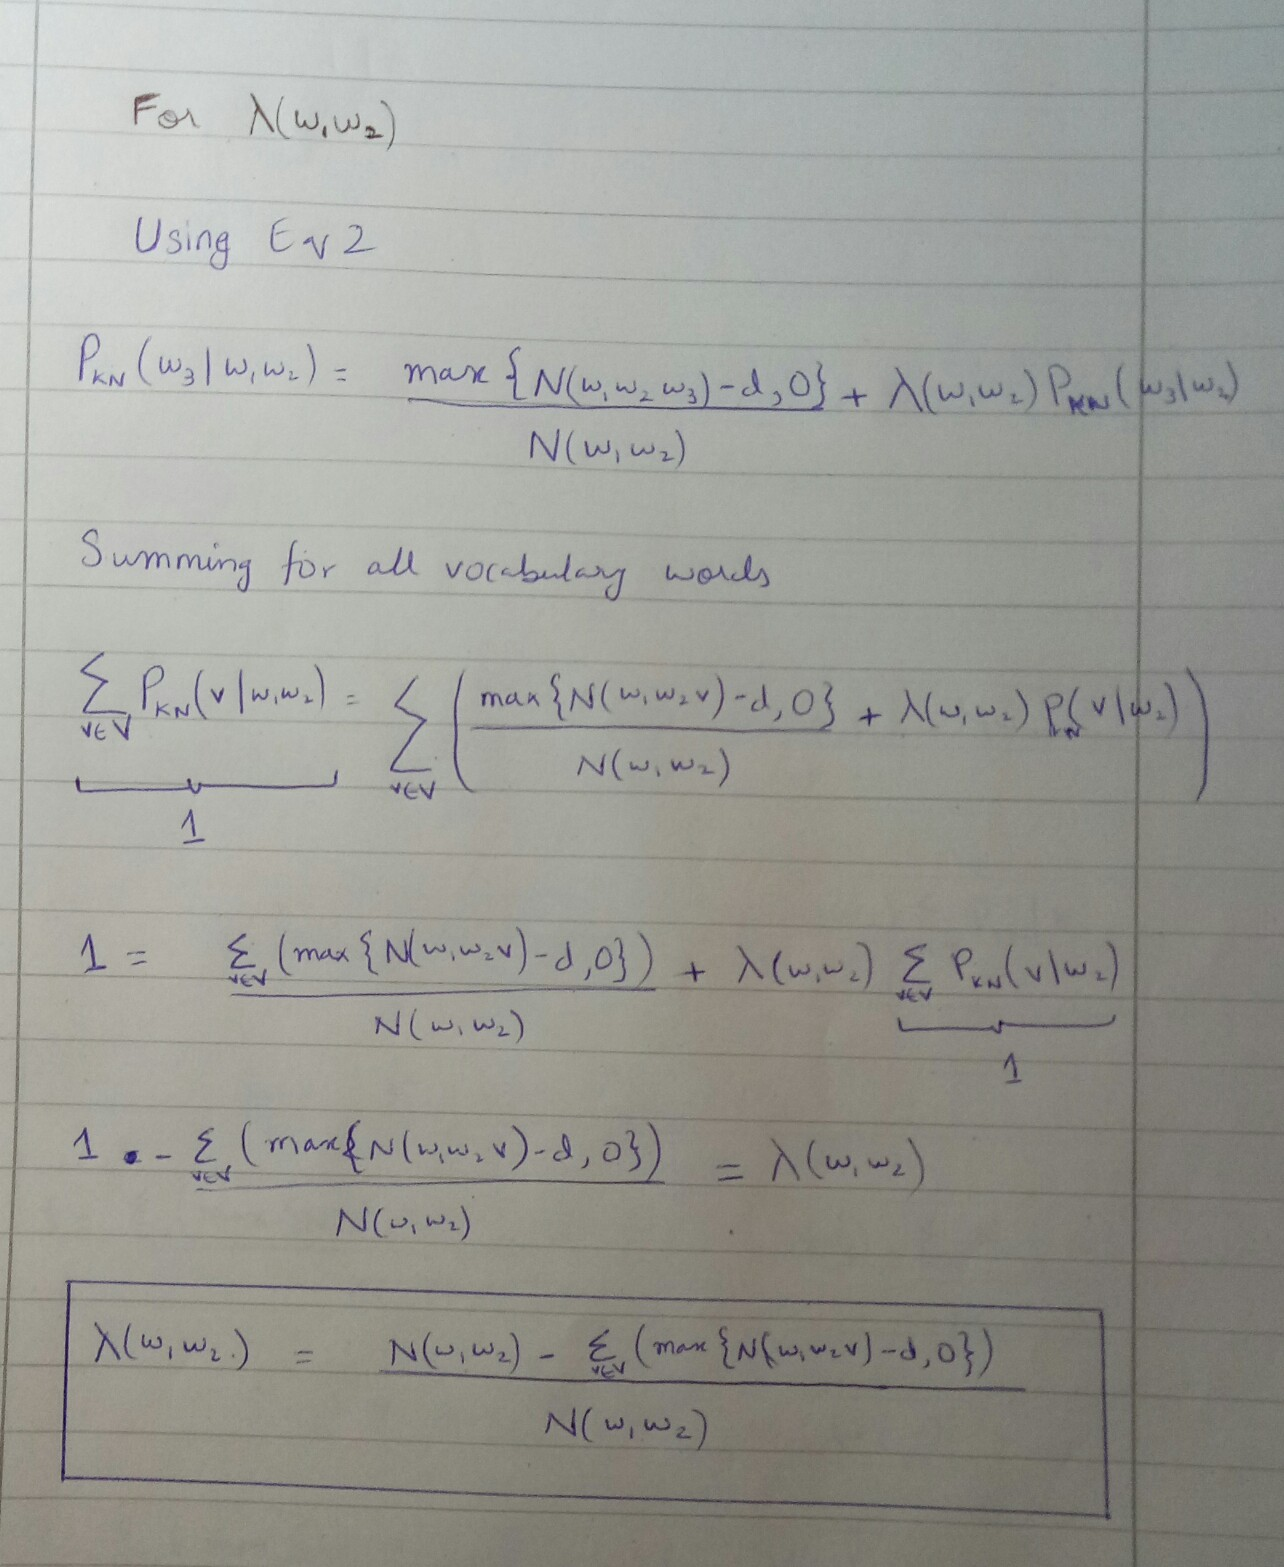</img>

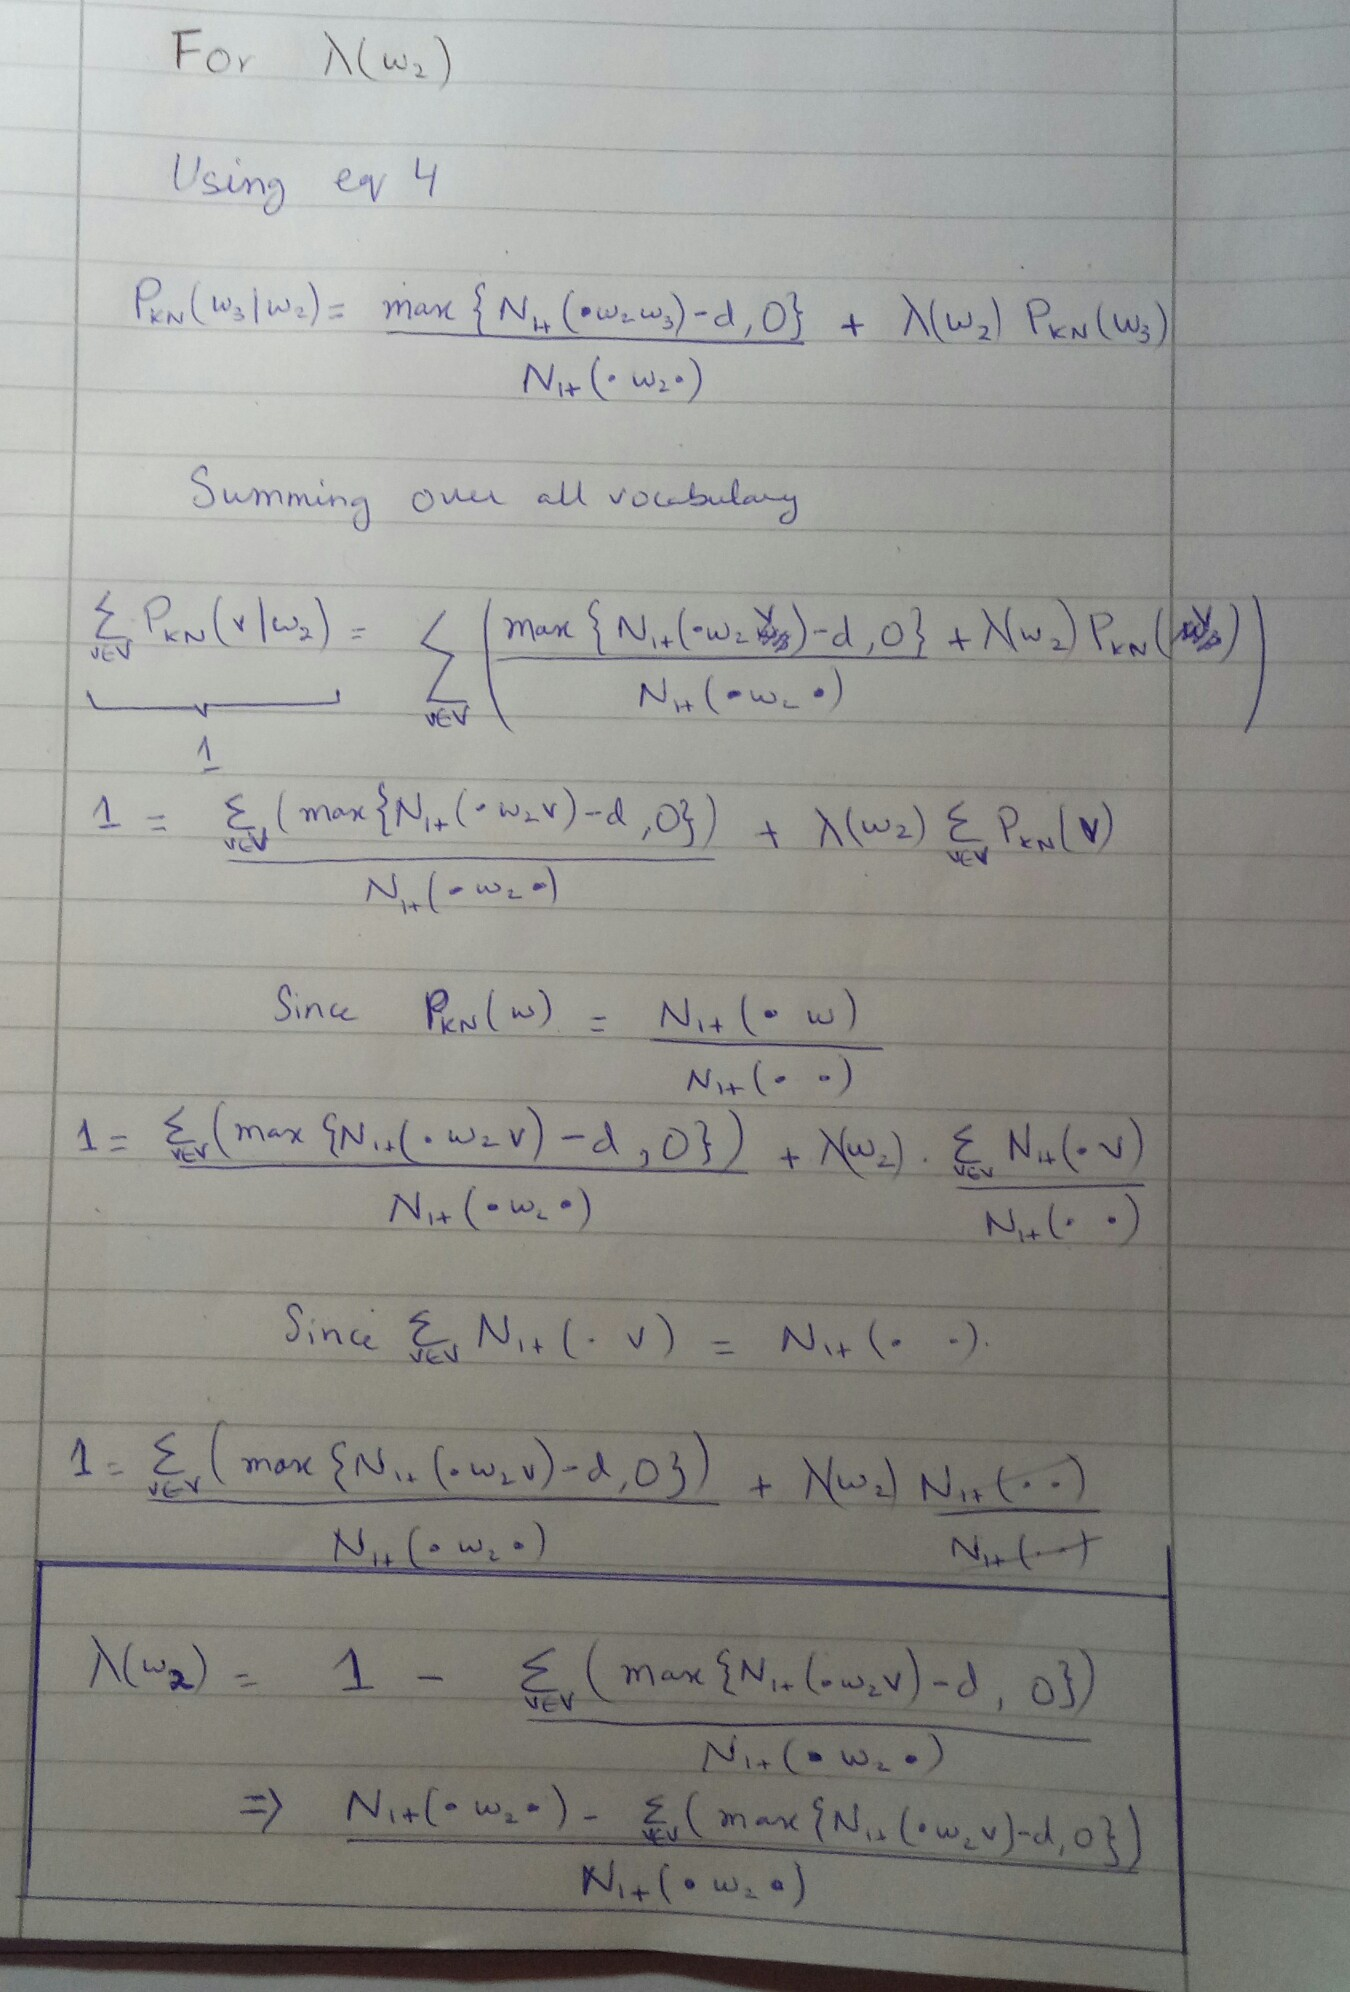</img>

In [1]:
# coding: utf-8
# SNLP - SoSe 2019 - ASSINGMENT VI

import math
import re
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

%matplotlib qt 


def word_ngrams(tokenized_text, n):
    return [tuple(tokenized_text[i:i + n]) for i in range(0, len(tokenized_text)-n+1)]

def tokenize(text):
    "List all the word tokens (consecutive letters) in a text. Normalize to lowercase."
    return re.findall("[a-z]+", text.replace("'", '').lower())

class ngram_LM:
    """A class to represent a language model."""

    def __init__(self, n, ngram_counts, vocab, unk=False):
        """"Make a n-gram language model, given a vocab and
            data structure for n-gram counts."""

        self.n = n

        self.vocab = vocab

        self.V = len(vocab)

        self.ngram_counts = ngram_counts

    # YOUR CODE HERE
    # START BY MAKING THE RIGHT COUNTS FOR THIS PARTICULAR self.n
        # for unigrams, we only need total word count
        if n == 1:
            self.total_count = sum(self.ngram_counts.values())
        # for bigrams, we need total count wrt each word. In our language, it is history count.
        elif n == 2:
            self.history_count = Counter()
            for k, v in self.ngram_counts.items():
                self.history_count[k[0]] = self.history_count[k[0]] + v
            # since we only count for the first word in the tuple, we will always
            # miss counting </s>. However, since the frequency of </s> is the same
            # as the frequency of <s>, we can simply assign it equal to it.
            self.history_count['</s>'] = self.history_count['<s>']



    def estimate_prob(self, history, word):
        """Estimate probability of a word given a history."""
        if history == '':
            # unigram
            word_frequency = self.ngram_counts[tuple([word])]
            return word_frequency/self.total_count

        else:
            # bigram
            word_frequency = self.ngram_counts[tuple([history, word])]
            history_count = self.history_count[history]
            if history_count == 0:
                return 0
            return word_frequency/history_count


    def estimate_smoothed_prob(self, history, word, alpha = 0.5):
        """Estimate probability of a word given a history with Lidstone smoothing."""

        if history == '':
            # unigram
            word_frequency = self.ngram_counts[tuple([word])]
            return (word_frequency + alpha)/(alpha*self.V +self.total_count)

        else:
            # bigram
            word_frequency = self.ngram_counts[tuple([history, word])]
            history_count = self.history_count[history]
            return (word_frequency + alpha)/(alpha*self.V + history_count)

    def getN1plus(self, word):
        # currently implemented for N1+(.,w)
        count = 0
        for v in self.vocab:
            if self.ngram_counts[tuple([v,word])] > 0:
                count = count + 1
        return count

    
    def kneser_Ney_smoothing(self, history, word):
        # currently implemented only for history = ''
        
        # out of vocab case
        if word not in self.vocab:
            return 1/self.V
        numerator = self.getN1plus(word)
        denominator = len(self.ngram_counts)
        return numerator/denominator
    


    def logP(self, history, word):
        """Return base-2 log probablity."""
        prob = self.estimate_smoothed_prob(history, word)
        log_prob = math.log(prob, 2)
        return log_prob


    def score_sentence(self, sentence):
        """Given a sentence, return score."""
        log_prob_sum = 0
        for i in range(len(sentence)):
            history = sentence[i][0]
            word = sentence[i][1]
            log_prob = self.logP(history, word)
            log_prob_sum += log_prob
        normalized_log_prob_sum = (-1 / len(sentence)) * log_prob_sum
        return normalized_log_prob_sum


    def test_LM(self):
        """Test whether or not the probability mass sums up to one."""

        precision = 10**-8

        if self.n == 1:

            P_sum = sum(self.estimate_prob('', w) for w in self.vocab)

            assert abs(1.0 - P_sum) < precision, 'Probability mass does not sum up to one.'

        elif self.n == 2:
            histories = ['the', 'in', 'at', 'blue', 'white']

            for h in histories:

                P_sum = sum(self.estimate_prob(h, w) for w in self.vocab)

                assert abs(1.0 - P_sum) < precision, 'Probability mass does not sum up to one for history' + h

        print('TEST SUCCESSFUL!')



    def test_smoohted_LM(self):
        """Test whether or not the smoothed probability mass sums up to one."""
        precision = 10**-8

        if self.n == 1:

            P_sum = sum(self.estimate_smoothed_prob('', w) for w in self.vocab)

            assert abs(1.0 - P_sum) < precision, 'Probability mass does not sum up to one.'

        elif self.n == 2:
            histories = ['the', 'in', 'at', 'blue', 'white']

            for h in histories:

                P_sum = sum(self.estimate_smoothed_prob(h, w) for w in self.vocab)

                assert abs(1.0 - P_sum) < precision, 'Probability mass does not sum up to one for history' + h

        print('TEST SUCCESSFUL!')


    def perplexity(self, test_corpus, alpha):

        likelihood = 0
        for sentence in test_corpus:
            try:
                if self.n == 1:
                    prob = self.estimate_smoothed_prob('', sentence[0], alpha)
                elif self.n ==2:
                    prob = self.estimate_smoothed_prob(sentence[0], sentence[1], alpha)
                likelihood += math.log2(prob)
            except:
                if alpha == 0:
                    continue 

        perplexity = math.pow(2, (-1*likelihood)/len(test_corpus))
        return perplexity


In [2]:
# main
filename= 'corpus.sent.en.train'
with open(filename, encoding='utf-8', errors='replace') as f:
    # read entire file
    text = f.read() 

# tokenize it
tokenized_text = tokenize(text)
unigrams = Counter(word_ngrams(tokenized_text,1))
unigram_vocabulary = list(unigrams.keys())
unigram_vocabulary = [i[0] for i in unigram_vocabulary]

bigrams = Counter(word_ngrams(tokenized_text,2))
bigram_vocabulary = [i for i in unigram_vocabulary]
bigram_vocabulary.extend(['<s>','</s>'])



## 1.1 (b)

In [3]:
words = ['york', 'matter']
unigram_LM = ngram_LM(1, unigrams, unigram_vocabulary)
bigram_LM = ngram_LM(2, bigrams, bigram_vocabulary)
for word in words:
    print('\n\n------ For Word "{}"------\n\n'.format(word))
    print('N(w) is {}'.format(unigram_LM.ngram_counts[tuple([word])]))
    print('N1+(.,w) is {}'.format(bigram_LM.getN1plus(word)))
    
    P_ML = unigram_LM.estimate_prob('',word)
    log2P_ML = -math.log(P_ML, 2)
    print('-log2P_ML(w) is {}'.format(log2P_ML))
    
    P_Lids = unigram_LM.estimate_smoothed_prob('',word,1)
    log2P_Lids =  -math.log(P_Lids, 2)
    print('-log2PLids(w) is {}'.format(log2P_Lids))
    
    P_kn = bigram_LM.kneser_Ney_smoothing('',word)
    log2P_kn = -math.log(P_kn, 2)
    print('-log2Pkn(w) is {}'.format(log2P_kn))






------ For Word "york"------


N(w) is 2362
N1+(.,w) is 9
-log2P_ML(w) is 12.262037520135516
-log2PLids(w) is 12.27271171382925
-log2Pkn(w) is 18.075287629817616


------ For Word "matter"------


N(w) is 2367
N1+(.,w) is 275
-log2P_ML(w) is 12.258986778798059
-log2PLids(w) is 12.269662262174144
-log2Pkn(w) is 13.141924822847903


<table>
  <tr>
    <th></th>
    <th>w = ‘york’</th>
    <th>w = ‘matter’</th>
  </tr>
  <tr>
    <td>N(w)</td>
    <td>2374</td>
    <td>2367</td>
  </tr>
  <tr>
    <td>N1+(.w)</td>
    <td>9</td>
    <td>269</td>
  </tr>
  <tr>
    <td>-log2PML(w)</td>
    <td>12.258</td>
    <td>12.262</td>
  </tr>
  <tr>
    <td>-log2PLids(w)</td>
    <td>12.268</td>
    <td>12.273</td>
  </tr>
  <tr>
    <td>-log2PKN(w)</td>
    <td>18.063</td>
    <td>13.161</td>
  </tr>
</table>

For "york", the counts are almost equal to "matter". However, It appears as the suffix of only 9 bigram types compared to 269 for "matter". Based on formula 5, this implies that Pkn would be smaller and its negative log hence would be larger.

The values of ML and PLids focus on the actual counts of the unigrams. This means that even though a word might occur fewer times in context, if it has high unigram count, it would have high probability. By making the counts based on bigram types, the probabilities reflect the actual probability of the word in the context (some particular history).

Since their actual counts are close, their PML and PLids are almost the same, whereas the PKN is very different. This is also observed as york is used with only a handful words like new, whereas matter can be used with many prefixes. Hence, matter has a higher KN probability than york even though their counts are very similar.

## 1.1 (C)

A major difference is that absolute discounting uses actual counts in calculating the discounted probability whereas in kneser Ney, we only  use actual counts in computing the discounted probability for the highest order ngram.

Consider the case of a bigram. In absolute discounting, the lowest order discounting probability, Pabs(w_i), will use the exact unigram counts to calculate the discounted probability which will be weighted by lambda function. 

Intuitively, using the raw unigram probability doesn't make sense. As shown in example above, york and matter have the same unigram probabilities but if we consider them in the context of diversity (i.e. the number of bigram types they can produce), it is clear that one is far more diverse than the other. This means we should instead of looking at raw unigram probabilities, consider this "diversity factor" of the unigram. This is what KN smoothing does. The backing off probabilities are calculated using N1+ function, which gives higher probabilities to unigrams which can make more diverse bigrams.

## 2.1 A, B

In [4]:
dickens_filename= 'train/dickens.en.train'
doyle_filename = 'train/doyle.en.train'
twain_filename = 'train/twain.en.train'

with open(dickens_filename, encoding='utf-8', errors='replace') as f:
    # read entire file
    dickens_text = f.read() 
    f.close()
with open(doyle_filename, encoding='utf-8', errors='replace') as f:
    # read entire file
    doyle_text = f.read() 
    f.close()
with open(twain_filename, encoding='utf-8', errors='replace') as f:
    # read entire file
    twain_text = f.read() 
    f.close()

dickens_sent = nltk.sent_tokenize(dickens_text)
doyle_sent = nltk.sent_tokenize(doyle_text)
twain_sent = nltk.sent_tokenize(twain_text)

tokenized_dickens = []
tokenized_doyle = []
tokenized_twain = []

for sent in dickens_sent:
    tokenized_dickens.extend(tokenize(sent))
    
for sent in doyle_sent:
    tokenized_doyle.extend(tokenize(sent))
    
for sent in twain_sent:
    tokenized_twain.extend(tokenize(sent))

dickens_unigrams = word_ngrams(tokenized_dickens, 1)
doyle_unigrams = word_ngrams(tokenized_doyle, 1)
twain_unigrams = word_ngrams(tokenized_twain, 1)

dickens_bigrams = word_ngrams(tokenized_dickens, 2)
doyle_bigrams = word_ngrams(tokenized_doyle, 2)
twain_bigrams = word_ngrams(tokenized_twain, 2)

dickens_unigram_counts = Counter(dickens_unigrams)
doyle_unigram_counts = Counter(doyle_unigrams)
twain_unigram_counts = Counter(twain_unigrams)

dickens_bigram_counts = Counter(dickens_bigrams)
doyle_bigram_counts = Counter(doyle_bigrams)
twain_bigram_counts = Counter(twain_bigrams)

## 2.1 C

In [5]:
print('Dickens top 15 unigrams:', dickens_unigram_counts.most_common(15))
print('Doyle top 15 unigrams:', doyle_unigram_counts.most_common(15))
print('Twain top 15 unigrams:', twain_unigram_counts.most_common(15))

print('Dickens top 15 bigrams:', dickens_bigram_counts.most_common(15))
print('Doyle top 15 bigrams:', doyle_bigram_counts.most_common(15))
print('Twain top 15 bigrams:', twain_bigram_counts.most_common(15))

Dickens top 15 unigrams: [(('the',), 65439), (('and',), 50578), (('to',), 36773), (('of',), 36288), (('a',), 28847), (('i',), 25128), (('in',), 24195), (('that',), 18049), (('was',), 17260), (('he',), 16283), (('it',), 16088), (('his',), 15937), (('her',), 12926), (('with',), 12582), (('you',), 11696)]
Doyle top 15 unigrams: [(('the',), 72028), (('of',), 34862), (('and',), 34405), (('a',), 31079), (('to',), 30829), (('i',), 30810), (('that',), 21445), (('in',), 21171), (('it',), 20715), (('was',), 18734), (('he',), 17945), (('you',), 16908), (('his',), 14661), (('is',), 12663), (('had',), 11265)]
Twain top 15 unigrams: [(('the',), 67252), (('and',), 59973), (('a',), 34946), (('to',), 33282), (('of',), 30456), (('i',), 24367), (('it',), 23727), (('was',), 20762), (('in',), 19609), (('he',), 18230), (('that',), 16879), (('you',), 12025), (('his',), 10684), (('but',), 10439), (('for',), 10150)]
Dickens top 15 bigrams: [(('of', 'the'), 6563), (('in', 'the'), 6147), (('to', 'the'), 3511), (

### We don't see a noticeable difference between either the unigrams or bigrams of the three authors. This is because the most frequent unigrams and bigrams are not related to the content of the text but the language itself. Since all three are in English, we expect to see the same most frequent unigrams and bigrams

## 2.1 D

In [6]:
dickens_unigram_lm = ngram_LM(1, dickens_unigram_counts, dickens_unigram_counts.keys())
dickens_bigram_lm = ngram_LM(2, dickens_bigram_counts, dickens_unigram_counts.keys())
doyle_unigram_lm = ngram_LM(1, doyle_unigram_counts, doyle_unigram_counts.keys())
doyle_bigram_lm = ngram_LM(2, doyle_bigram_counts, doyle_unigram_counts.keys())
twain_unigram_lm = ngram_LM(1, twain_unigram_counts, twain_unigram_counts.keys())
twain_bigram_lm = ngram_LM(2, twain_bigram_counts, twain_unigram_counts.keys())

## 2.1 E

In [7]:
seg1_filename = 'test/seg1.test'
seg2_filename = 'test/seg2.test'
seg3_filename = 'test/seg3.test'

with open(seg1_filename, encoding='utf-8', errors='replace') as f:
    # read entire file
    seg1_text = f.read() 
    f.close()

with open(seg2_filename, encoding='utf-8', errors='replace') as f:
    # read entire file
    seg2_text = f.read() 
    f.close()

with open(seg3_filename, encoding='utf-8', errors='replace') as f:
    # read entire file
    seg3_text = f.read() 
    f.close()

seg1_sent = nltk.sent_tokenize(seg1_text)
seg2_sent = nltk.sent_tokenize(seg2_text)
seg3_sent = nltk.sent_tokenize(seg3_text)

tokenized_seg1 = []
tokenized_seg2 = []
tokenized_seg3 = []

for sent in seg1_sent:
    tokenized_seg1.extend(tokenize(sent))
    
for sent in seg2_sent:
    tokenized_seg2.extend(tokenize(sent))
    
for sent in seg3_sent:
    tokenized_seg3.extend(tokenize(sent))

seg1_unigrams = word_ngrams(tokenized_seg1, 1)
seg2_unigrams = word_ngrams(tokenized_seg2, 1)
seg3_unigrams = word_ngrams(tokenized_seg3, 1)

seg1_bigrams = word_ngrams(tokenized_seg1, 2)
seg2_bigrams = word_ngrams(tokenized_seg2, 2)
seg3_bigrams = word_ngrams(tokenized_seg3, 2)


## 2.1 F

In [8]:
seg1_dickens_p_uni = dickens_unigram_lm.perplexity(seg1_unigrams, 0.2)
seg1_doyle_p_uni = doyle_unigram_lm.perplexity(seg1_unigrams, 0.2)
seg1_twain_p_uni = twain_unigram_lm.perplexity(seg1_unigrams, 0.2)

seg2_dickens_p_uni = dickens_unigram_lm.perplexity(seg2_unigrams, 0.2)
seg2_doyle_p_uni = doyle_unigram_lm.perplexity(seg2_unigrams, 0.2)
seg2_twain_p_uni = twain_unigram_lm.perplexity(seg2_unigrams, 0.2)

seg3_dickens_p_uni = dickens_unigram_lm.perplexity(seg3_unigrams, 0.2)
seg3_doyle_p_uni = doyle_unigram_lm.perplexity(seg3_unigrams, 0.2)
seg3_twain_p_uni = twain_unigram_lm.perplexity(seg3_unigrams, 0.2)

table_uni = {}
table_uni['Seg 1'] = [seg1_dickens_p_uni, seg1_doyle_p_uni, seg1_twain_p_uni]
table_uni['Seg 2'] = [seg2_dickens_p_uni, seg2_doyle_p_uni, seg2_twain_p_uni]
table_uni['Seg 3'] = [seg3_dickens_p_uni, seg3_doyle_p_uni, seg3_twain_p_uni]

table_uni = pd.DataFrame.from_dict(table_uni, orient='index')
table_uni.columns = ['Dickens', 'Doyle', 'Twain']
table_uni['Predicted Author'] = table_uni.idxmin(axis=1)
pd.set_option('display.float_format', lambda x: '%.1f' % x)
print(table_uni)

       Dickens  Doyle  Twain Predicted Author
Seg 1    993.0 1137.9 1098.7          Dickens
Seg 2    994.7  690.9 1033.0            Doyle
Seg 3    885.5  926.4  546.5            Twain


## 2.1 G

In [9]:
seg1_dickens_p_bi = dickens_bigram_lm.perplexity(seg1_bigrams, 0.2)
seg1_doyle_p_bi = doyle_bigram_lm.perplexity(seg1_bigrams, 0.2)
seg1_twain_p_bi = twain_bigram_lm.perplexity(seg1_bigrams, 0.2)

seg2_dickens_p_bi = dickens_bigram_lm.perplexity(seg2_bigrams, 0.2)
seg2_doyle_p_bi = doyle_bigram_lm.perplexity(seg2_bigrams, 0.2)
seg2_twain_p_bi = twain_bigram_lm.perplexity(seg2_bigrams, 0.2)

seg3_dickens_p_bi = dickens_bigram_lm.perplexity(seg3_bigrams, 0.2)
seg3_doyle_p_bi = doyle_bigram_lm.perplexity(seg3_bigrams, 0.2)
seg3_twain_p_bi = twain_bigram_lm.perplexity(seg3_bigrams, 0.2)

table_bi = {}
table_bi['Seg 1'] = [seg1_dickens_p_bi, seg1_doyle_p_bi, seg1_twain_p_bi]
table_bi['Seg 2'] = [seg2_dickens_p_bi, seg2_doyle_p_bi, seg2_twain_p_bi]
table_bi['Seg 3'] = [seg3_dickens_p_bi, seg3_doyle_p_bi, seg3_twain_p_bi]

table_bi = pd.DataFrame.from_dict(table_bi, orient='index')
table_bi.columns = ['Dickens', 'Doyle', 'Twain']
table_bi['Predicted Author'] = table_bi.idxmin(axis=1)
print(table_bi)

       Dickens  Doyle  Twain Predicted Author
Seg 1   1435.2 1713.5 1959.4          Dickens
Seg 2   1100.8  418.1 1394.3            Doyle
Seg 3   1298.1 1411.9  375.1            Twain


### Based on the perplixeties, both the unigram and bigram LMs predicted the authors correctly. This is perhaps due to certain word choices of different authors that cause their word distribution to be similar but different to other authors.